## **Global output results**
---


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from sklearn import preprocessing
import json
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
from collections import defaultdict

sys.path.append('../../2_fit_models/dmdm')
from data_io import get_file_dir, load_animal_list, load_cv_arr, load_data
from data_labels import create_abort_mask, partition_data_by_session
from plot_model_perform import create_cv_frame_for_plotting, plot_state_Wk, plot_state_dwelltime
from plotting_utils import load_global_glmhmm_result, calc_dwell_time, flatten_list, load_glmhmm_result
from plot_animal_behav import plot_PC, plot_CC, plot_FArate

sys.path.append('../../1_preprocess_data/dmdm')
from preprocessing_utils import load_animal_eid_dict
import matplotlib.ticker as ticker

In /nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two mi

In [3]:
# ------- setup variables -------
dnames = ['dataAllHumans', 'dataAllMiceTraining']
C = 3  # number of output types/categories
D = 1  # data (observations) dimension
labels_for_plot_y = ['CSize', 'COnset', 'Outcome +1', 'Outcome +2', 'Outcome +3', 'Outcome +4', 'Outcome +5', 'bias']

save_figures = True
figure_dir = get_file_dir().parents[1] / 'figures'
figure_dir.mkdir(parents=True, exist_ok=True)

model = 'GLM_HMM_y'
Ks = [2,4]

In [4]:
dnames = ['dataAllHumans']
Ks = [2]

In [5]:
dname = 'dataAllMiceTraining'
K = 3
dnames = ['dataAllMiceTraining']
Ks = [3]

In [6]:
regularization = None

In [7]:
data_dir =  get_file_dir().parents[1] / "data" / "dmdm" / dname / 'data_for_cluster'

In [8]:
# ------- setup path and load data -------
data_2_dir =  get_file_dir().parents[1] / "data" / "dmdm" / dname / 'data_for_cluster' / "data_by_animal"
results_2_dir = get_file_dir().parents[1] / "results" / "dmdm_individual_fit" / dname
figure_dir = get_file_dir().parents[1] / 'figures'
figure_dir.mkdir(parents=True, exist_ok=True)

# read in data and train/test split
animal_list = load_animal_list(data_2_dir / 'animal_list.npz')

print('Animals fitted: {}'.format(animal_list))

Animals fitted: ['M_AK001' 'M_AK004' 'M_AK005' 'M_AK008' 'M_IO125' 'M_IO127' 'M_IO128'
 'M_IO132' 'M_IO135' 'M_IO136' 'M_IO137' 'M_IO138' 'M_ML007' 'M_ML008']


In [9]:
# Load raw data eids
animal_list = load_animal_list(
    data_dir / 'data_by_animal' / 'animal_list.npz')
animal_eid_dict = load_animal_eid_dict(
    data_dir / 'final_animal_eid_dict.json')

In [20]:
# Each animal
for animal in animal_list:
    # Load GLM-HMM results
    states_max_posterior, _, inpt_rt, _, session, _, _, mask, hmm_params \
        = load_glmhmm_result(animal, K, model, results_2_dir, data_2_dir)

    # Create trial IDs
    trialnum_all = []
    for eid in animal_eid_dict[animal]:

        raw_session_id = eid.split('Subjects/')[1]
        # Get animal:
        animal = raw_session_id.split('/')[0]
        # Replace '/' with dash in session ID
        session_id = raw_session_id.replace('/', '-')

        trialnum = np.load(data_dir.parent / Path(eid) / '_dmdm_trials.trial.npy')[0]
        trialnum2 = [session_id + '-' + str(int(t)) for t in trialnum]
        trialnum_all.append(trialnum2)

    # Save outputs in json file
    rdict = defaultdict(list)
    for zk in range(K):
        b = np.where(states_max_posterior == zk)
        x = np.array(flatten_list(trialnum_all))[b]
        rdict[zk] = x.tolist()

    out_json = json.dumps(rdict)
    f = open(str(figure_dir / "state_session_trial_{}_K_{}_{}_{}.json".format(dname, K, regularization, animal)), "w")
    f.write(out_json)
    f.close()

M_AK001
M_AK004
M_AK005
M_AK008
M_IO125
M_IO127
M_IO128
M_IO132
M_IO135
M_IO136
M_IO137
M_IO138
M_ML007
M_ML008


In [10]:
bestK_animals = {'M_AK001':2, 'M_AK004':3, 'M_AK005':3,
              'M_AK008':3, 'M_IO125':3,  'M_IO127':3,  
              'M_IO128':2, 'M_IO132':2,  'M_IO135':2, 
              'M_IO136':2, 'M_IO137':2,  'M_IO138':3,  
              'M_ML007':3, 'M_ML008':3}

In [11]:
# Each animal
for animal in animal_list:
    # Load GLM-HMM results
    Kanimal = bestK_animals[animal]
    states_max_posterior, _, inpt_rt, _, session, _, _, mask, hmm_params \
        = load_glmhmm_result(animal, Kanimal, model, results_2_dir, data_2_dir)

    # Create trial IDs
    trialnum_all = []
    for eid in animal_eid_dict[animal]:

        raw_session_id = eid.split('Subjects/')[1]
        # Get animal:
        animal = raw_session_id.split('/')[0]
        # Replace '/' with dash in session ID
        session_id = raw_session_id.replace('/', '-')

        trialnum = np.load(data_dir.parent / Path(eid) / '_dmdm_trials.trial.npy')[0]
        trialnum2 = [session_id + '-' + str(int(t)) for t in trialnum]
        trialnum_all.append(trialnum2)

    # Save outputs in json file
    rdict = defaultdict(list)
    for zk in range(K):
        b = np.where(states_max_posterior == zk)
        x = np.array(flatten_list(trialnum_all))[b]
        rdict[zk] = x.tolist()

    out_json = json.dumps(rdict)
    f = open(str(figure_dir / "state_session_trial_{}_Kbest_{}_{}_{}.json".format(dname, K, regularization, animal)), "w")
    f.write(out_json)
    f.close()

M_AK001
M_AK004
M_AK005
M_AK008
M_IO125
M_IO127
M_IO128
M_IO132
M_IO135
M_IO136
M_IO137
M_IO138
M_ML007
M_ML008


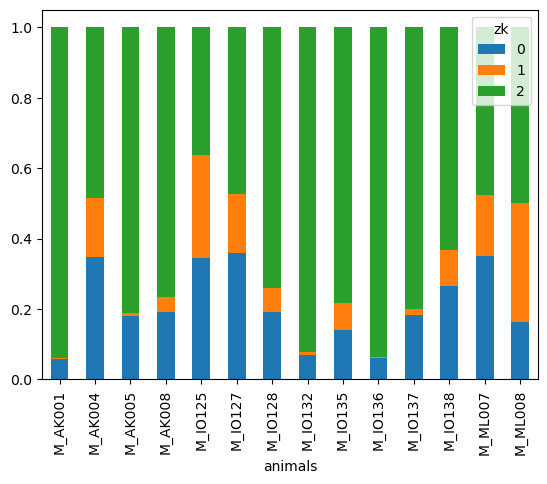

In [9]:
for i, dname in enumerate(dnames):
    K = Ks[i]

    data_dir =  get_file_dir().parents[1] / "data" / "dmdm" / dname / 'data_for_cluster'
    # results_dir = get_file_dir().parents[1] / "results" / "dmdm_global_fit" / dname

    # Load GLM-HMM results
    states_max_posterior, _, inpt_rt, _, session, _, _, mask, hmm_params \
        = load_global_glmhmm_result(K, model, data_dir, regularization)

    # Load raw data eids
    animal_list = load_animal_list(
        data_dir / 'data_by_animal' / 'animal_list.npz')
    animal_eid_dict = load_animal_eid_dict(
        data_dir / 'final_animal_eid_dict.json')

    # Create trial IDs
    trialnum_all = []
    for z, animal in enumerate(animal_list):
        sess_counter = 0
        for eid in animal_eid_dict[animal]:

            raw_session_id = eid.split('Subjects/')[1]
            # Get animal:
            animal = raw_session_id.split('/')[0]
            # Replace '/' with dash in session ID
            session_id = raw_session_id.replace('/', '-')

            trialnum = np.load(data_dir.parent / Path(eid) / '_dmdm_trials.trial.npy')[0]
            trialnum2 = [session_id + '-' + str(int(t)) for t in trialnum]
            trialnum_all.append(trialnum2)

    # Save outputs in json file
    rdict = defaultdict(list)
    for zk in range(K):
        b = np.where(states_max_posterior == zk)
        x = np.array(flatten_list(trialnum_all))[b]
        rdict[zk] = x.tolist()

    out_json = json.dumps(rdict)
    f = open(str(figure_dir / "state_session_trial_{}_K_{}_{}.json".format(dname, K, regularization)), "w")
    f.write(out_json)
    f.close()

    zkd = pd.DataFrame(
        {'zk': states_max_posterior,
        'trial_ids': flatten_list(trialnum_all)
        })

    zkd = pd.DataFrame(
        {'zk': states_max_posterior,
        'trial_ids': flatten_list(trialnum_all)
        })

    if dname == 'dataAllHumans':
        zkd['animals'] = 'H' + zkd.trial_ids.str.split('_').str[3]
        zkd['sessions'] = zkd.trial_ids.str.split('-').str[1]
    elif dname == 'dataAllMiceTraining':
        zkd['animals'] = zkd.trial_ids.str.split('-').str[0]
        zkd['sessions'] = zkd.trial_ids.str.split('-').str[1]

    zk_fraction_occupancy = zkd.groupby(['animals'])['zk'].value_counts(normalize=True).unstack().fillna(0)
    ax = zk_fraction_occupancy.plot.bar(stacked=True)

In [7]:
data_dir =  get_file_dir().parents[1] / "data" / "dmdm" / dname / 'data_for_cluster'
results_dir = get_file_dir().parents[1] / "results" / "dmdm_global_fit" / dname

# Load GLM-HMM results
states_max_posterior, _, inpt_rt, _, session, _, stim_onset, mask, hmm_params \
    = load_global_glmhmm_result(K, model, data_dir)

# Load raw data eids
animal_list = load_animal_list(
    data_dir / 'data_by_animal' / 'animal_list.npz')
animal_eid_dict = load_animal_eid_dict(
    data_dir / 'final_animal_eid_dict.json')

# Create trial IDs
trialnum_all = []
for z, animal in enumerate(animal_list):
    sess_counter = 0
    for eid in animal_eid_dict[animal]:

        raw_session_id = eid.split('Subjects/')[1]
        # Get animal:
        animal = raw_session_id.split('/')[0]
        # Replace '/' with dash in session ID
        session_id = raw_session_id.replace('/', '-')

        trialnum = np.load(data_dir.parent / Path(eid) / '_dmdm_trials.trial.npy')[0]
        trialnum2 = [session_id + '-' + str(int(t)) for t in trialnum]
        trialnum_all.append(trialnum2)

In [8]:
zkd = pd.DataFrame(
    {'zk': states_max_posterior,
     'trial_id': flatten_list(trialnum_all)
    })

if dname == 'dataAllHumans':
    zkd['animal'] = 'H' + zkd.trial_id.str.split('_').str[3]
    zkd['session'] = zkd.trial_id.str.split('-').str[1]
elif dname == 'dataAllMiceTraining':
    zkd['animal'] = zkd.trial_id.str.split('-').str[0]
    zkd['session'] = zkd.trial_id.str.split('-').str[1]

In [9]:
zk_fraction_occupancy = zkd.groupby(['animal'])['zk'].value_counts(normalize=True).unstack().fillna(0)

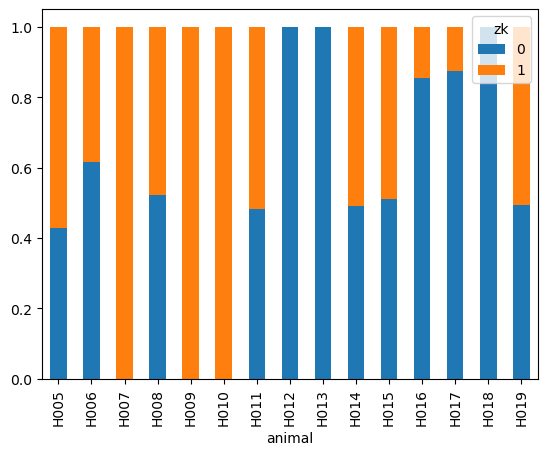

In [10]:
ax = zk_fraction_occupancy.plot.bar(stacked=True)

In [ ]:
np.where(states_max_posterior == 0)[0]

In [ ]:
a = stim_onset[np.where(states_max_posterior == 0)[0],:]

In [ ]:
len(a)

In [ ]:
sum(a<10)

In [ ]:
b = stim_onset[np.where(states_max_posterior == 1)[0],:]

In [ ]:
len(b)

In [ ]:
sum(b<10)

In [ ]:
zkd

In [ ]:
zkd

In [ ]:
def calc_switching_time(df: pd.DataFrame, normalize=True) -> pd.DataFrame:
    switch_across_sessions = []
    grouped_by_session = df.groupby(['session'])

    for sess, df_s in grouped_by_session:
        states_max_posterior = df_s['zk'].values
        diffs = np.diff(states_max_posterior)
        state_change_num = sum(np.abs(diffs) > 0)
        if normalize:
            state_change_num = state_change_num / len(states_max_posterior)

        switch_across_sessions.append(state_change_num)
    return switch_across_sessions

In [ ]:
goo = calc_switching_time(zkd, normalize=False)

In [ ]:
goo

In [ ]:
# consider abort states_max_posterior nan

In [ ]:
master_y_inpt, master_y, master_session, master_rt, master_stim_onset